In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

In [2]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

In [3]:
def generate_random_graph(node_count, connectivity):
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(1, node_count + 1))

    # Ensure at least min_edges are added for connectivity

    # Add edges to achieve the desired connectivity
    while len(list(nx.isolates(G))) >0:
        node1 = random.randint(1, node_count)
        node2 = random.randint(1, node_count)
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)

    # Add remaining edges randomly
    remaining_edges = int(node_count * (node_count - 1) * connectivity / 2)
    for _ in range(remaining_edges):
        node1 = random.randint(1, node_count)
        node2 = random.randint(1, node_count)
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)

    return G

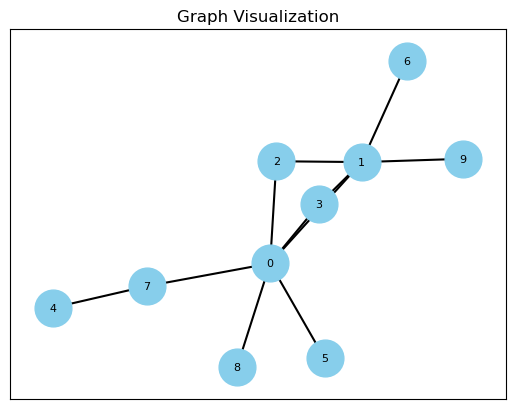

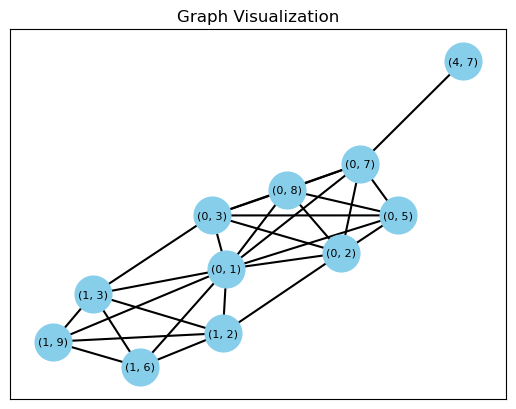

In [4]:
G = nx.scale_free_graph(n=10,alpha=.41).to_undirected()
G.remove_edges_from(list(nx.selfloop_edges(G)))
G = nx.Graph(G)
visualize_graph(G)
visualize_graph(nx.line_graph(G))

In [5]:
v_arr = np.array([])
r_arr = np.array([])

for i in range (1000):
    G = nx.scale_free_graph(n=10,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    lg = nx.line_graph(G)
    pager = nx.pagerank(lg,max_iter=100)
    v_arr = np.append(v_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(10, 1)
    lg = nx.line_graph(gr)
    pager = nx.pagerank(lg,max_iter=100)
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    

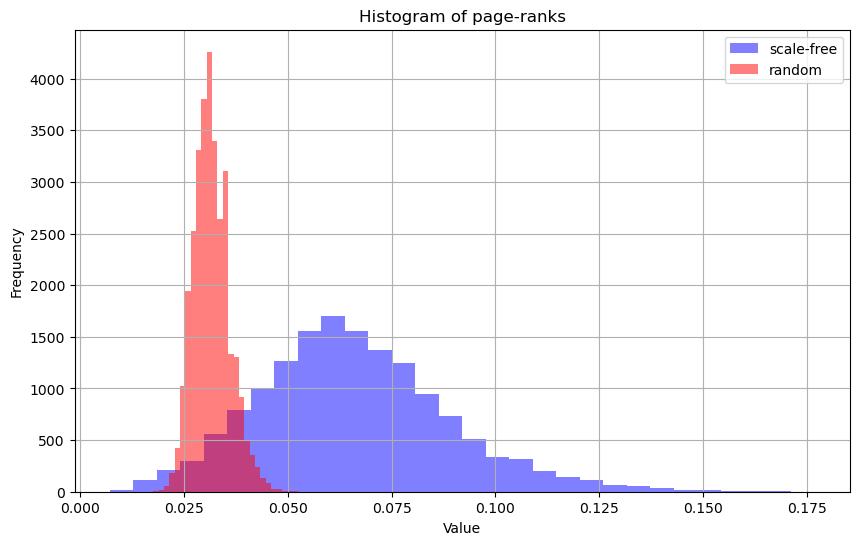

In [6]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(v_arr, bins=30, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=30, alpha=0.5, color='red', label='random')

plt.title('Histogram of page-ranks')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()
